In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import sys
sys.path.append('/Users/abhishek/Projects/experimental-timeflow/')
import timeflow as tflow
import timesynth as ts
%matplotlib inline

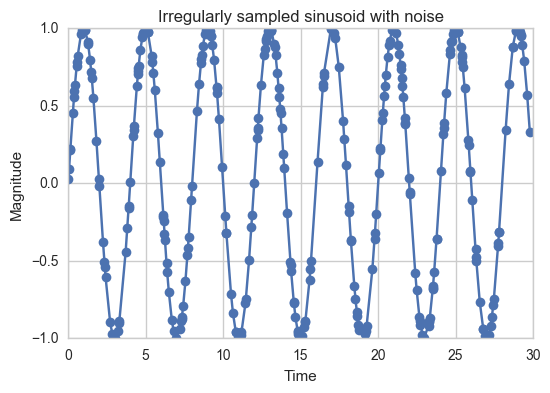

In [2]:
#Initializing TimeSampler
time_sampler = ts.TimeSampler(stop_time=30)
#Sampling regular time samples
irregular_time_samples = time_sampler.sample_irregular_time(num_points=600, keep_percentage=50)
#Initializing Sinusoidal signal
sinusoid = ts.signals.Sinusoidal(frequency=0.25)
#Initializing Gaussian noise
white_noise = ts.noise.GaussianNoise(std=0.3)
#Initializing TimeSeries class with the signal and noise objects
timeseries = ts.TimeSeries(sinusoid, noise_generator=None)
#Sampling using the irregular time samples
samples, signals, errors = timeseries.sample(irregular_time_samples)
#Plotting the series
plt.plot(irregular_time_samples, samples, marker='o')
plt.xlabel('Time')
plt.ylabel('Magnitude')
plt.title('Irregularly sampled sinusoid with noise')

In [3]:
X, Y, time_vector = tflow.features.irregular_prediction(irregular_time_samples, samples)
num_training_points = 100
num_validation_points = 100
X_train = X[:num_training_points, :]
Y_train = Y[:num_training_points, :]
X_valid = X[num_training_points:num_training_points+num_validation_points, :]
Y_valid = Y[num_training_points:num_training_points+num_validation_points, :]
X_test = X[num_training_points+num_validation_points:, :]
Y_test = Y[num_training_points+num_validation_points:, :]

In [4]:
input_size = 4
hidden_size = 50
output_size = 1

In [6]:
with tf.variable_scope('Input'):
    inputs = tflow.placeholders.prediction.input_placeholder(input_size)
with tf.variable_scope('Input_LSTM_Layer'):
    input_lstm_layer = tflow.layers.InputLSTMLayer(inputs, input_size)
with tf.variable_scope('LSTM_Layer'):
    lstm_layer = tflow.layers.LSTMLayer(input_size, hidden_size, input_lstm_layer)
with tf.variable_scope('Regression_Layer'):
    reg_layer = tflow.layers.RegressionLayer(hidden_size, output_size, lstm_layer)

In [7]:
outputs = reg_layer.get_outputs()[:, 0, :]

In [8]:
y = tflow.placeholders.prediction.output_placeholder(output_size)

In [9]:
# Defining MSE as the loss function
with tf.variable_scope('RMSE'):
    loss_func = tflow.utils.metrics.RMSE(outputs, y)
# Defining R2 for additional logging
with tf.variable_scope('R2'):
    R2 = tflow.utils.metrics.R2(outputs, y)

In [10]:
# Training with Adadelta Optimizer
train_step = tf.train.RMSPropOptimizer(learning_rate=0.05).minimize(loss_func)

In [11]:
# Starting tensorflow session
sess=tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

In [12]:
monitor = tflow.trainer.AutomatedTrainingMonitor(inputs, y, X_train, Y_train,
                                                 train_step, loss_func, sess, training_steps=500,
                                                 validation_input=X_valid, validation_output=Y_valid,
                                                 early_stopping_rounds=150)

In [13]:
%time writer = monitor.train()

Final Validation loss:  0.0216905251145
Number of Iterations:  321
CPU times: user 1min 10s, sys: 1min 4s, total: 2min 15s
Wall time: 1min 30s


In [14]:
predicted_series = sess.run(outputs,feed_dict={inputs:X})

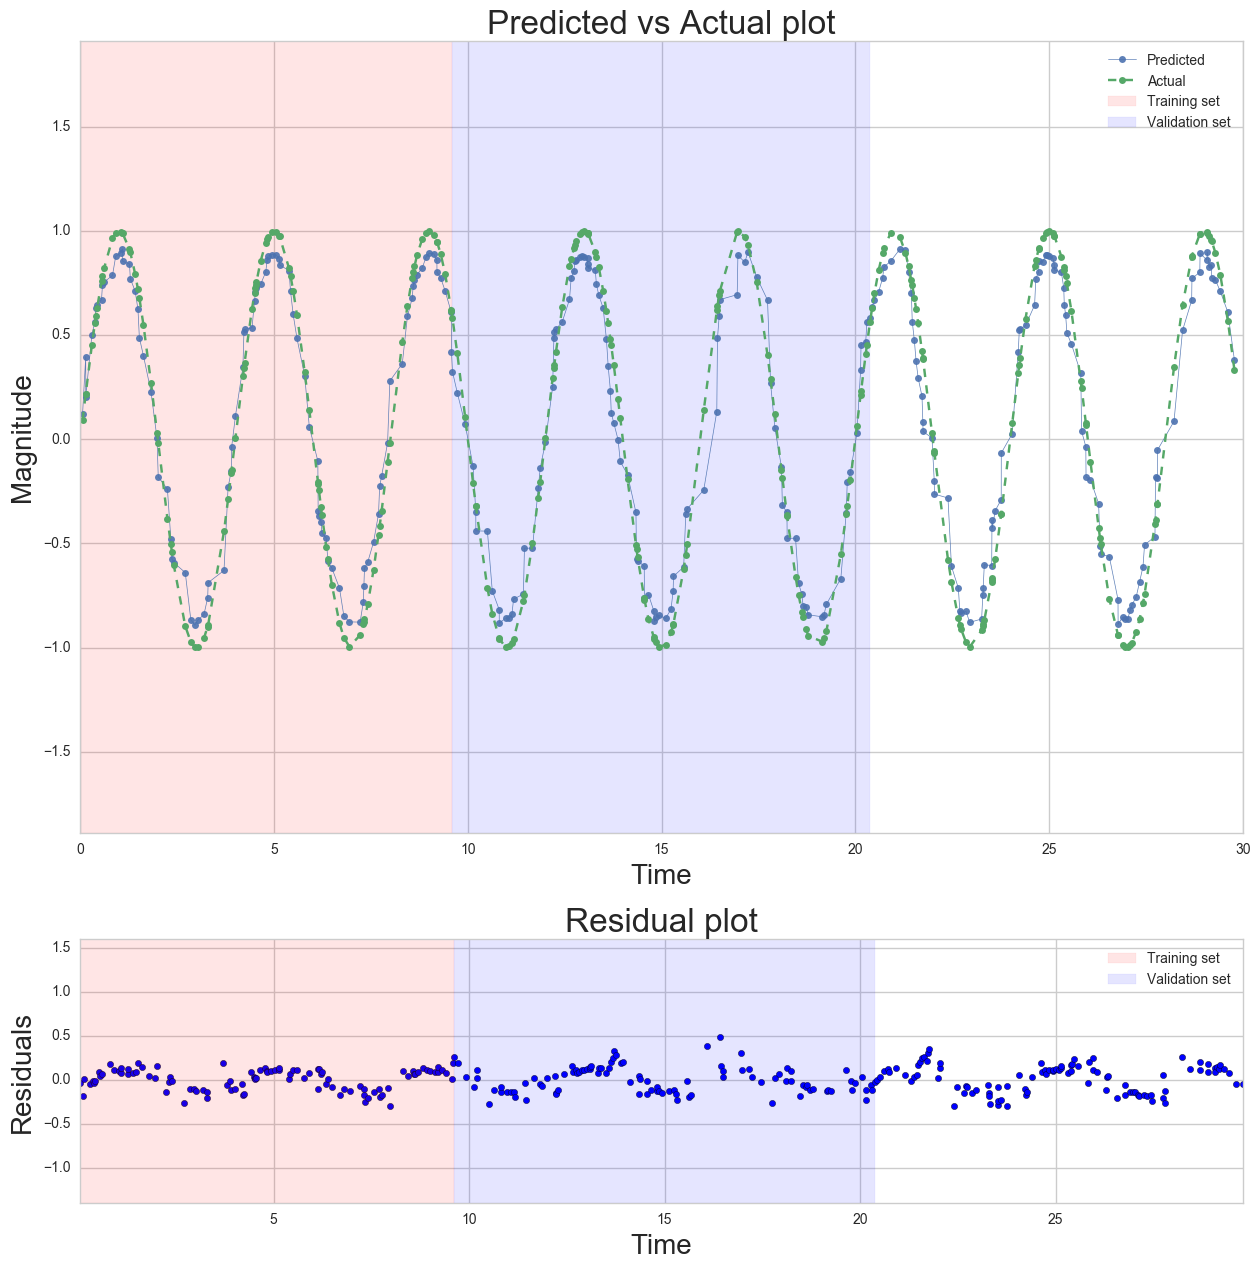

In [15]:
tflow.utils.plotting.plot_residuals(predicted_series, Y, time_vector,
                                    num_training_points, num_validation_points)

In [ ]:
class LSTMLayerWithReg(NNLayer):
    """
    This layer implements the LSTM cell.
    """
    """
    This layer implements the LSTM cell.
    """
    def __init__(self, input_dim, hidden_layer_size, input_layer):
        """Initialize LSTMLayer class

        Parameters
        ----------
        input_dim : integer
            Input dimensions
        hidden_layer_size : integer
            Size of the memory in LSTM cell
        input_layer : layers object
            Preceding layers object

        """
        self.input_dim = input_dim
        self.hidden_layer_size = hidden_layer_size
        self.inputs = input_layer.get_outputs()

        # Initializing the weights and biases
        self.Wi = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Ui = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bi = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wf = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Uf = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bf = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wog = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Uog = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bog = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.Wc = tf.Variable(tf.zeros([self.input_dim, self.hidden_layer_size]))
        self.Uc = tf.Variable(tf.zeros([self.hidden_layer_size, self.hidden_layer_size]))
        self.bc = tf.Variable(tf.zeros([self.hidden_layer_size]))

        self.initial_hidden = tf.zeros([1, self.hidden_layer_size])
        self.initial_hidden= tf.pack([self.initial_hidden, self.initial_hidden])

    def forward_step(self, previous_memory, input_):
        """
        Generates the next forward LSTM operation

        Parameters
        ----------
        previous_memory : list
            List of the previous memory and hidden output tensors
        input_ : tf.tensor
            Input tensor

        Returns
        ----------
        list
            New updated memory and hidden output tensors

        """
        previous_hidden_state, c_prev = tf.unpack(previous_memory)
        # Input gate
        i= tf.sigmoid(
            tf.matmul(input_,self.Wi)+tf.matmul(previous_hidden_state,self.Ui) + self.bi
        )
        # Forget Gate
        f= tf.sigmoid(
            tf.matmul(input_,self.Wf)+tf.matmul(previous_hidden_state,self.Uf) + self.bf
        )
        # Output Gate
        o= tf.sigmoid(
            tf.matmul(input_,self.Wog)+tf.matmul(previous_hidden_state,self.Uog) + self.bog
        )
        # New Memory Cell
        c_= tf.nn.tanh(
            tf.matmul(input_,self.Wc)+tf.matmul(previous_hidden_state,self.Uc) + self.bc
        )
        # Final Memory cell
        c= f*c_prev + i*c_

        # Current Hidden state
        current_hidden_state = o*tf.nn.tanh(c)
        return tf.pack([current_hidden_state,c])

    # Function for getting all hidden state.
    def get_outputs(self):
        """
        Iterates through time/ sequence to get all hidden state

        Returns
        ----------
        tf.Tensor
            Output tensor

        """
        # Getting all hidden state throuh time
        inputs_shape = self.inputs.get_shape()
        if inputs_shape[0] == 1:
            self.inputs = tf.expand_dims(self.inputs[0, :, :], 1)
            all_hidden_states = tf.scan(self.forward_step,
                                        self.inputs,
                                        initializer=self.initial_hidden,
                                        name='states')
            all_hidden_states = all_hidden_states[:, 0, :, :]
        else:
            all_hidden_states = tf.map_fn(self.get_batch_outputs,
                                          self.inputs)
        return all_hidden_states

    def get_batch_outputs(self, single_input):
        single_input = tf.expand_dims(single_input, 1)
        all_hidden_states = tf.scan(self.forward_step,
                                    single_input,
                                    initializer=self.initial_hidden,
                                    name='states')
        all_hidden_states = all_hidden_states[:, 0, :, :]
        return all_hidden_states
